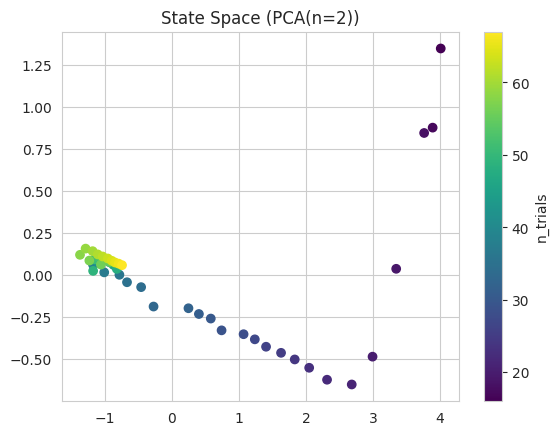

In [13]:
from pathlib import Path
from carps.analysis.gather_data import read_jsonl_content
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn

setup_seaborn()


rundir = Path("../runs_eval/Jump-LtH/BBOB/bbob/2/1/0/1/DACBOEnvLogs.jsonl")
obs = read_jsonl_content(rundir)
obs_keys = list(obs.iloc[0]["observation"].keys())

expanded = obs["observation"].apply(pd.Series)
expanded.columns = obs_keys
obs = obs.drop(columns="observation").join(expanded)
obs[obs_keys] = obs[obs_keys].map(lambda x: x[0])


X = obs[obs_keys].to_numpy()
y = obs["n_trials"].to_numpy()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111)

sc = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y,          # color by y
    cmap='viridis'  # choose any colormap
)

plt.colorbar(sc, ax=ax, label="n_trials")
ax.set_title("State Space (PCA(n=2))")
plt.show()